# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
import math
from tqdm import tqdm
import pickle
import numpy as np
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
sizes = train['sizes']
coords = train['coords']

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    random_state=0)

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = 32*32*3

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 27446
Number of testing examples = 12630
Image data shape = 3072
Number of classes = 43


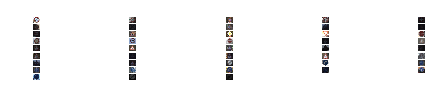

In [11]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import numpy.random as random
import matplotlib.gridspec as gridspec
from tqdm import tqdm

def explore(X_train):
    sample_size = 5 
    count = 1 
    for i in range(n_classes):
        ind = y_train == i
        subset_x = X_train[ind,] #get all images that belong to class i
        plt.subplot(n_classes,sample_size,count)
        plt.imshow(subset_x[1])
        plt.axis('off')
        count +=1
    plt.show()
        
explore(X_train)


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [15]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
from sklearn.preprocessing import OneHotEncoder

def OHE_labels(Y_tr,N_classes):
    OHC = OneHotEncoder()
    
    Y_ohc = OHC.fit(np.arange(N_classes).reshape(-1, 1))
    Y_labels = Y_ohc.transform(Y_tr.reshape(-1, 1)).toarray()
    return Y_labels

def next_batch(x, y, batch_index, batch_size):
    start = batch_index + 1
    end = start + batch_size
    return x[start:end, :], y[start:end]

train_labels = OHE_labels(y_train,n_classes)
test_labels = OHE_labels(y_test,n_classes)
valid_labels = OHE_labels(y_valid,n_classes)

train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)
valid_labels = valid_labels.astype(np.float32)

print("train label shape=",train_labels.shape)
print("test label shape=",test_labels.shape)
print("valid label shape=",valid_labels.shape)
        
layer_width = {
    'layer_1': 32,
    'layer_2': 64,
    'layer_3': 128,
    'fully_connected': 512
}

# Store layers weight & bias
weights = {
    'layer_1': tf.Variable(tf.truncated_normal([5, 5, 3, layer_width['layer_1']])),
    'layer_2': tf.Variable(tf.truncated_normal([5, 5, layer_width['layer_1'], layer_width['layer_2']])),
    'layer_3': tf.Variable(tf.truncated_normal([5, 5, layer_width['layer_2'], layer_width['layer_3']])),
    'fully_connected': tf.Variable(tf.truncated_normal([128, layer_width['fully_connected']])),
    'out': tf.Variable(tf.truncated_normal([layer_width['fully_connected'], n_classes]))
}
biases = {
    'layer_1': tf.Variable(tf.zeros(layer_width['layer_1'])),
    'layer_2': tf.Variable(tf.zeros(layer_width['layer_2'])),
    'layer_3': tf.Variable(tf.zeros(layer_width['layer_3'])),
    'fully_connected': tf.Variable(tf.zeros(layer_width['fully_connected'])),
    'out': tf.Variable(tf.zeros(n_classes))
}


def conv2d(x, W, b, strides=4):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.tanh(x)


def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

# Create model
def conv_net(x, weights, biases):    
    print ("x-shape = ", x.get_shape())
    image = tf.reshape(x, shape=[-1, 32, 32, 3])
    print ("image-shape = ", image.get_shape())
    # Layer 1
    conv1 = conv2d(image, weights['layer_1'], biases['layer_1'])
    print ("conv1-shape before maxpool = ", conv1.get_shape())
    conv1 = maxpool2d(conv1)
    print ("conv1-shape = ", conv1.get_shape())
    
    # Layer 2
    conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])
    print ("conv2-shape before max pool= ", conv2.get_shape())
    conv2 = maxpool2d(conv2)
    print ("conv2-shape = ", conv2.get_shape())
 
    # Layer 3
    conv3 = conv2d(conv2, weights['layer_3'], biases['layer_3'])
    print ("conv3-shape before max pool = ", conv3.get_shape())
    conv3 = maxpool2d(conv3)
    print ("conv3-shape = ", conv3.get_shape())
  
    # Fully connected layer
    # Reshape conv3 output to fit fully connected layer input
    fc1 = tf.reshape( conv3, [-1, weights['fully_connected'].get_shape().as_list()[0]])
    print("fc1 shape = ", fc1.get_shape())
    fc1 = tf.add(tf.matmul(fc1, weights['fully_connected']), biases['fully_connected'])
    fc1 = tf.nn.tanh(fc1)

    # Output Layer - class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    print("out shape =", out.get_shape())
    return out


train label shape= (27446, 43)
test label shape= (12630, 43)
valid label shape= (11763, 43)


In [20]:
learning_rate = 0.001
batch_size = 512
training_epochs = 25
#training_epochs = 1

# tf Graph input
x = tf.placeholder("float", [None, 32, 32, 3])
y = tf.placeholder("float", [None, n_classes])


# define all the variables and functions
logits = conv_net(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)


# Initializing the variables
init = tf.initialize_all_variables()

print("Everything is defined")

x-shape =  (?, 32, 32, 3)
image-shape =  (?, 32, 32, 3)
conv1-shape before maxpool =  (?, 8, 8, 32)
conv1-shape =  (?, 4, 4, 32)
conv2-shape before max pool=  (?, 1, 1, 64)
conv2-shape =  (?, 1, 1, 64)
conv3-shape before max pool =  (?, 1, 1, 128)
conv3-shape =  (?, 1, 1, 128)
fc1 shape =  (?, 128)
out shape = (?, 43)
Everything is defined


In [21]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(training_epochs):
        batch_count = int(math.ceil(len(X_train)/batch_size))            
        # The training cycle
        for i in range(batch_count):
            
            batch_x, batch_y = next_batch(X_train,train_labels,i,batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
            
        # Display logs per epoch step
        c = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
    print("Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print(
        "Accuracy:",
        accuracy.eval({x: X_valid, y: valid_labels}))

Epoch: 0001 cost= 30.053089142
Epoch: 0002 cost= 15.568515778
Epoch: 0003 cost= 8.870595932
Epoch: 0004 cost= 7.282234192
Epoch: 0005 cost= 6.335186481
Epoch: 0006 cost= 5.876165390
Epoch: 0007 cost= 5.514448166
Epoch: 0008 cost= 5.272830963
Epoch: 0009 cost= 5.104325771
Epoch: 0010 cost= 4.949627876
Epoch: 0011 cost= 4.816656113
Epoch: 0012 cost= 4.696991444
Epoch: 0013 cost= 4.590035439
Epoch: 0014 cost= 4.483975410
Epoch: 0015 cost= 4.383374214
Epoch: 0016 cost= 4.283911228
Epoch: 0017 cost= 4.178747654
Epoch: 0018 cost= 4.077129364
Epoch: 0019 cost= 3.986568928
Epoch: 0020 cost= 3.908603907
Epoch: 0021 cost= 3.837081194
Epoch: 0022 cost= 3.769214630
Epoch: 0023 cost= 3.715661764
Epoch: 0024 cost= 3.667127609
Epoch: 0025 cost= 3.622915745
Optimization Finished!
Accuracy: 0.0546629


##### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [2]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### I split the data into test/validation and training data like so:
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
sizes = train['sizes']
coords = train['coords']

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    random_state=0)

### I also one hot encoded the labels like so:
def OHE_labels(Y_tr,N_classes):
    OHC = OneHotEncoder()
    
    Y_ohc = OHC.fit(np.arange(N_classes).reshape(-1, 1))
    Y_labels = Y_ohc.transform(Y_tr.reshape(-1, 1)).toarray()
    return Y_labels

def next_batch(x, y, batch_index, batch_size):
    start = batch_index + 1
    end = start + batch_size
    return x[start:end, :], y[start:end]

train_labels = OHE_labels(y_train,n_classes)
test_labels = OHE_labels(y_test,n_classes)
valid_labels = OHE_labels(y_valid,n_classes)

train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)
valid_labels = valid_labels.astype(np.float32)

print("train label shape=",train_labels.shape)
print("test label shape=",test_labels.shape)
print("valid label shape=",valid_labels.shape)

### I thought about grayscaling the image data but did not see how that would help

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
### I tried to setup a 3 layer conv network and the general idea was borrowed from the class
### It is essentially Image->conv, followed by max pooling->conv, followed by max pooling->fully connected->classifier
### I split the data into test/validation and training data like so:
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
sizes = train['sizes']
coords = train['coords']

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    random_state=0)

def conv_net(x, weights, biases):    
    print ("x-shape = ", x.get_shape())
    image = tf.reshape(x, shape=[-1, 32, 32, 3])
    print ("image-shape = ", image.get_shape())
    # Layer 1
    conv1 = conv2d(image, weights['layer_1'], biases['layer_1'])
    print ("conv1-shape before maxpool = ", conv1.get_shape())
    conv1 = maxpool2d(conv1)
    print ("conv1-shape = ", conv1.get_shape())
    
    # Layer 2
    conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])
    print ("conv2-shape before max pool= ", conv2.get_shape())
    conv2 = maxpool2d(conv2)
    print ("conv2-shape = ", conv2.get_shape())
 
    # Layer 3
    conv3 = conv2d(conv2, weights['layer_3'], biases['layer_3'])
    print ("conv3-shape before max pool = ", conv3.get_shape())
    conv3 = maxpool2d(conv3)
    print ("conv3-shape = ", conv3.get_shape())
  
    # Fully connected layer
    # Reshape conv3 output to fit fully connected layer input
    fc1 = tf.reshape( conv3, [-1, weights['fully_connected'].get_shape().as_list()[0]])
    print("fc1 shape = ", fc1.get_shape())
    fc1 = tf.add(tf.matmul(fc1, weights['fully_connected']), biases['fully_connected'])
    fc1 = tf.nn.tanh(fc1)

    # Output Layer - class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    print("out shape =", out.get_shape())
    return out

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [5]:
### Train your model here.
### Feel free to use as many code cells as needed.
### This is solved above, please look at code section '# Launch the graph'
### It is essentially Image->conv, followed by max pooling->conv, followed by max pooling->fully connected->classifier
### I also utilize gradient descent and a softmax loss function.


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
The training was done a portion of training data. I chose a batch size of 512 and training epochs of 50. The accuracy with epoch 25 hovered around 54-55%. I tried other epochs. With higher epoch of 50 accuracy went below 50% (which could be increased if i grayscaled the image)
For Optimizer i used gradient descent with a learning rate of 0.001.
For cost function i used softmax function as shown below

In [ ]:
learning_rate = 0.001
batch_size = 512
training_epochs = 50

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:** 
I first wrote a single layer neural network, which was slow and not as accurate. I went back to the class and saw that CNN can be effective, especially since they share weights and biases and can work with large data sets. So I chose that as a way to get to the results.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
import matplotlib.image as mpimg
import cv2

def resize():
    images = os.listdir("webimages/")
    for f in images:
        #reading in an image
        image = mpimg.imread(os.path.join("webimages/", f))
        print('This image is:', type(image), 'with dimesions:', image.shape)
        rows,cols,ch = image.shape
        r = 32.0 / image.shape[1]
        dim = (32, int(image.shape[0] * r))

        # perform the actual resizing of the image and show it
        resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        print('resized:', resized.shape)
        cv2.imwrite(os.path.join("webresized",f), resized)

resize()


This image is: <class 'numpy.ndarray'> with dimesions: (225, 225, 3)
resized: (32, 32, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (224, 225, 3)
resized: (31, 32, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (225, 225, 3)
resized: (32, 32, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (211, 239, 3)
resized: (28, 32, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (210, 240, 3)
resized: (28, 32, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (210, 240, 3)
resized: (28, 32, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (211, 239, 3)
resized: (28, 32, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (211, 239, 3)
resized: (28, 32, 3)


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.